In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date_list = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
print(most_recent_date_list)

[('2017-08-23',)]


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = most_recent_date_list[0][0]
most_recent_year = most_recent_date_list[0][0][:4]

# Calculate the date one year from the last date in data set.
previous_year = int(most_recent_year) - 1
last_year_date = str(previous_year) + most_recent_date[4:]

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(last_year_date, most_recent_date) )

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results[:],columns=['date', 'pcpr'])
#convert date column from String to date
df['date']= pd.to_datetime(df['date'])
df = df.set_index('date')
df.head(10)

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data




,pcpr
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,pcpr
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


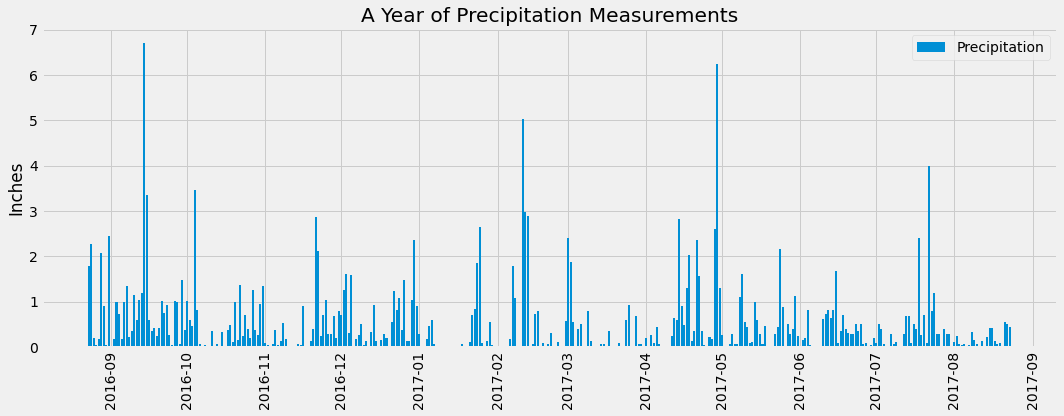

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))

#Needed when x axis is DateTimeIndex from df
ax.xaxis_date()

# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation = 90)
ax.set_ylabel('Inches')
ax.set_title('A Year of Precipitation Measurements')
ax.bar(df.index, df['pcpr'], label='Precipitation')
ax.legend()
plt.tight_layout()
plt.show()

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
results = session.query(Station).count()
print("Stations in Station table: ", results)
results = session.query(Measurement.station).distinct().count()
print("Stations with measurements:", results)

Stations in Station table:  9
Stations with measurements: 9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.station)]
top_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
top_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

temps = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
temps

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

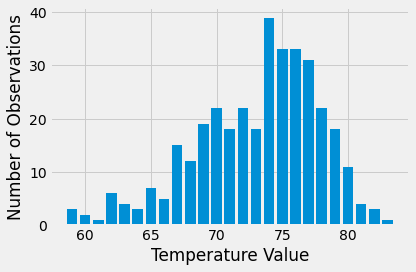

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


max_date = df.index[-1].date()
min_date = df.index[0].date()

#print(max_date, min_date)

#print(type(max_date))

sel = [Measurement.tobs, func.count(Measurement.tobs)]
results = session.query(*sel)\
.group_by(Measurement.tobs)\
.filter(Measurement.station == "USC00519281")\
.filter(Measurement.date.between(min_date, max_date)).all()

#print(results)

n_bins  = [temp_value[0] for temp_value in results ]
counts  = [temp_value[1] for temp_value in results]

#print(bins)
#print(counts)

fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.set_ylabel('Number of Observations')
axs.set_xlabel('Temperature Value')
axs.bar(n_bins, counts)
plt.show()


# Close session

In [17]:
# Close Session
session.close()